# RAS Commander: Parallel Plan Execution

This notebook demonstrates how to execute multiple HEC-RAS plans in parallel using the RAS Commander library. Parallel execution allows you to make better use of your computer's processing power by running multiple plans simultaneously.

## Operations Covered

1. **Project Initialization**: Initialize a HEC-RAS project and prepare it for parallel execution
2. **Parallel Execution of All Plans**: Run all plans in a project simultaneously
3. **Selective Parallel Execution**: Run only specific plans in parallel
4. **Dynamic Worker Allocation**: Automatically determine the optimal number of parallel workers
5. **Resource Management**: Optimize CPU core utilization for parallel runs
6. **Results Comparison**: Analyze and visualize execution performance

Let's begin by importing the necessary libraries and setting up our environment.

## Package Installation and Environment Setup
Uncomment and run package installation commands if needed

In [1]:
# Install ras-commander from pip (uncomment to install if needed)
#!pip install ras-commander
# This installs ras-commander and all dependencies

In [2]:
# Import all required modules

# Import all ras-commander modules
from ras_commander import *

# Import the required libraries for this notebook
import numpy as np
import pandas as pd
from IPython import display
from pathlib import Path
import matplotlib.pyplot as plt
import psutil  # For getting system CPU info
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import subprocess
import sys
import os
import shutil
import math  # Import math to avoid NameError in get_optimal_worker_count function

## Setting Up Our Working Environment

Let's set up our working directory and check the system resources available for parallel execution. This will help us make informed decisions about how many workers to use.

For this notebook we will be using the "Muncie" HEC Example Project

In [3]:
# Extract the Muncie example project
# The extract_project method downloads the project from GitHub if not already present,
# and extracts it to the example_projects folder
muncie_path = RasExamples.extract_project("Muncie")
print(f"Extracted project to: {muncie_path}")  

# Verify the path exists
print(f"Bald Eagle Creek project exists: {muncie_path.exists()}")


# Create compute folders
compute_folder = muncie_path.parent / "compute_test_parallel"
specific_compute_folder = muncie_path.parent / "compute_test_parallel_specific"
dynamic_compute_folder = muncie_path.parent / "compute_test_parallel_dynamic"

# Check system resources for parallel execution
cpu_count = psutil.cpu_count(logical=True)  # Logical cores (including hyper-threading)
physical_cores = psutil.cpu_count(logical=False)  # Physical cores only
memory_gb = psutil.virtual_memory().total / (1024**3)  # Total RAM in GB
available_memory_gb = psutil.virtual_memory().available / (1024**3)  # Available RAM in GB

print(f"System Resources:")
print(f"- {physical_cores} physical CPU cores ({cpu_count} logical cores with hyper-threading)")
print(f"- {memory_gb:.1f} GB total memory ({available_memory_gb:.1f} GB available)")

# Functions to help with resource management
def get_optimal_worker_count(cores_per_worker=2):
    """Calculate the optimal number of workers based on available physical cores."""
    optimal_workers = math.floor(physical_cores / cores_per_worker)
    return max(1, optimal_workers)  # Ensure at least 1 worker

print(f"\nFor parallel HEC-RAS execution:")
print(f"- With 2 cores per worker: Can use up to {get_optimal_worker_count(2)} parallel workers")
print(f"- With 4 cores per worker: Can use up to {get_optimal_worker_count(4)} parallel workers")
print(f"\nEach HEC-RAS instance typically requires 2-4 GB of RAM. Based on your available memory,")
print(f"you could reasonably run {math.floor(available_memory_gb / 3)} instances simultaneously.")

2025-03-19 17:12:55 - ras_commander.RasExamples - INFO - Found zip file: c:\GH\ras-commander\examples\Example_Projects_6_6.zip
2025-03-19 17:12:55 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2025-03-19 17:12:55 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2025-03-19 17:12:55 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2025-03-19 17:12:55 - ras_commander.RasExamples - INFO - Extracting project 'Muncie'
2025-03-19 17:12:55 - ras_commander.RasExamples - INFO - Project 'Muncie' already exists. Deleting existing folder...
2025-03-19 17:12:56 - ras_commander.RasExamples - INFO - Existing folder for project 'Muncie' has been deleted.
2025-03-19 17:12:56 - ras_commander.RasExamples - INFO - Successfully extracted project 'Muncie' to c:\GH\ras-commander\examples\example_projects\Muncie


Extracted project to: c:\GH\ras-commander\examples\example_projects\Muncie
Bald Eagle Creek project exists: True
System Resources:
- 4 physical CPU cores (8 logical cores with hyper-threading)
- 31.9 GB total memory (16.7 GB available)

For parallel HEC-RAS execution:
- With 2 cores per worker: Can use up to 2 parallel workers
- With 4 cores per worker: Can use up to 1 parallel workers

Each HEC-RAS instance typically requires 2-4 GB of RAM. Based on your available memory,
you could reasonably run 5 instances simultaneously.


## Understanding Parallel Execution in HEC-RAS

HEC-RAS simulations can be computationally intensive, especially for large models or long simulation periods. Parallel execution allows you to run multiple plans simultaneously, making better use of your computer's processing power.

### Key Concepts in Parallel Execution

1. **Workers**: Each worker is a separate process that can execute a HEC-RAS plan. The `max_workers` parameter determines how many plans can be executed simultaneously.

2. **Cores per Worker**: Each worker (HEC-RAS instance) can utilize multiple CPU cores. The `num_cores` parameter sets how many cores each worker uses.

3. **Resource Balancing**: Effective parallel execution requires balancing the number of workers with the cores per worker. Too many workers or too many cores per worker can lead to resource contention and slower overall performance.

4. **Worker Folders**: Each worker gets its own folder with a copy of the project, allowing for isolated execution.

### Parallel vs. Sequential Execution

- **Parallel**: Multiple plans run simultaneously (good for independent plans, faster overall completion)
- **Sequential**: Plans run one after another (good for dependent plans, consistent resource usage)

### Optimal Configuration

The optimal configuration depends on your hardware and the specific plans you're running:

- For most models, 2-4 cores per worker provides good performance
- Set `max_workers` based on available physical cores: `max_workers = floor(physical_cores / cores_per_worker)`
- Ensure you have enough memory: each worker typically needs 2-4 GB of RAM

Now, let's download and extract our example project.

## Downloading and Extracting Example HEC-RAS Project

Let's use the `RasExamples` class to download and extract the "Balde Eagle Creek" example project.

## Step 1: Project Initialization

Let's initialize the HEC-RAS project using the `init_ras_project()` function. We'll store the initialized object in a variable to use later, rather than relying on the global `ras` object. This approach is more suitable for working with multiple projects or compute folders.

In [4]:
# Initialize the source project
source_project = init_ras_project(muncie_path, "6.6")
print(f"Initialized source project: {source_project.project_name}")

# Display the current plan files in the project
print("\nAvailable plans in the project:")
display.display(source_project.plan_df)

# Check how many plans we have
plan_count = len(source_project.plan_df)
print(f"Found {plan_count} plans in the project")

2025-03-19 17:12:56 - ras_commander.RasPrj - INFO - Initializing global 'ras' object via init_ras_project function.
2025-03-19 17:12:56 - ras_commander.RasPrj - INFO - Project initialized. ras_object project folder: c:\GH\ras-commander\examples\example_projects\Muncie


Initialized source project: Muncie

Available plans in the project:


,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,DSS File,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,01,01,01,Unsteady Multi 9-SA run,5.00,9-SAs,"02JAN1900,0000,02JAN1900,2400",15SEC,5MIN,1,...,dss,1,NaN,NaN,None,01,c:\GH\ras-commander\examples\example_projects\...,01,c:\GH\ras-commander\examples\example_projects\...,c:\GH\ras-commander\examples\example_projects\...
1,03,01,02,Unsteady Run with 2D 50ft Grid,5.10,2D 50ft Grid,"02JAN1900,0000,02JAN1900,2400",10SEC,5MIN,-1,...,dss,1,Pardiso (Direct),2D Interior Area,None,02,c:\GH\ras-commander\examples\example_projects\...,01,c:\GH\ras-commander\examples\example_projects\...,c:\GH\ras-commander\examples\example_projects\...
2,04,01,04,Unsteady Run with 2D 50ft User n Value R,5.10,50ft User n Regions,"02JAN1900,0000,02JAN1900,2400",10SEC,5MIN,1,...,dss,1,Pardiso (Direct),2D Interior Area,None,04,c:\GH\ras-commander\examples\example_projects\...,01,c:\GH\ras-commander\examples\example_projects\...,c:\GH\ras-commander\examples\example_projects\...


Found 3 plans in the project


## Understanding the RasCmdr.compute_parallel Method

Before we start executing plans in parallel, let's understand the `compute_parallel()` method from the `RasCmdr` class.

### Key Parameters

- `plan_number` (Union[str, List[str], None]): Plan number(s) to compute. If None, all plans are computed.
- `max_workers` (int): Maximum number of parallel workers (default: 2).
- `num_cores` (int): Number of cores to use per plan computation (default: 2).
- `clear_geompre` (bool): Whether to clear geometry preprocessor files (default: False).
- `ras_object` (Optional[RasPrj]): Specific RAS object to use. If None, uses global ras instance.
- `dest_folder` (Union[str, Path, None]): Destination folder for computed results.
- `overwrite_dest` (bool): Whether to overwrite existing destination folder (default: False).

### Return Value
- `Dict[str, bool]`: Dictionary of plan numbers and their execution success status.

### Key Concepts

1. **Worker Assignment**: Plans are assigned to workers in a round-robin fashion. For example, with 3 workers and 5 plans, workers would be assigned as follows: Worker 1: Plans 1 & 4, Worker 2: Plans 2 & 5, Worker 3: Plan 3.

2. **Worker Folders**: Each worker gets its own folder (a subdirectory of the destination folder) for isolated execution.

3. **Result Consolidation**: After all plans are executed, results are consolidated into the destination folder.

4. **Resource Management**: Each worker can use multiple cores as specified by `num_cores`.

Now, let's see how this works in practice.

## Step 2: Parallel Execution of All Plans

Let's execute all plans in the project in parallel. We'll use 3 workers, with 2 cores per worker. This approach is good when you have multiple plans that are independent of each other and you want to complete them as quickly as possible.

In [5]:
print("Executing all plans in parallel...")
print("This may take several minutes...")

# Create compute folder if it doesn't exist
compute_folder.mkdir(parents=True, exist_ok=True)

# Define the parameters for parallel execution
max_workers = 4
cores_per_worker = 1

print(f"Using {max_workers} parallel workers, each with {cores_per_worker} cores")
print(f"Destination folder: {compute_folder}")

# Record start time for performance measurement
start_time = time.time()

# Execute all plans in parallel
results_all = RasCmdr.compute_parallel(
    max_workers=max_workers,
    num_cores=cores_per_worker,
    dest_folder=compute_folder,
    overwrite_dest=True,
    ras_object=source_project
)

# Record end time and calculate duration
end_time = time.time()
total_duration = end_time - start_time

print(f"Parallel execution of all plans completed in {total_duration:.2f} seconds")

# Create a DataFrame from the execution results for better visualization
results_df = pd.DataFrame([
    {"Plan": plan, "Success": success}
    for plan, success in results_all.items()
])

# Sort by plan number
results_df = results_df.sort_values("Plan")

# Display the results
print("\nExecution Results:")
display.display(results_df)

2025-03-19 17:12:56 - ras_commander.RasCmdr - INFO - Destination folder 'c:\GH\ras-commander\examples\example_projects\compute_test_parallel' exists. Overwriting as per overwrite_dest=True.
2025-03-19 17:12:56 - ras_commander.RasCmdr - INFO - Copied project folder to destination: c:\GH\ras-commander\examples\example_projects\compute_test_parallel


Executing all plans in parallel...
This may take several minutes...
Using 4 parallel workers, each with 1 cores
Destination folder: c:\GH\ras-commander\examples\example_projects\compute_test_parallel


2025-03-19 17:12:56 - ras_commander.RasCmdr - INFO - Adjusted max_workers to 3 based on the number of plans: 3
2025-03-19 17:12:56 - ras_commander.RasCmdr - INFO - Created worker folder: c:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 1]
2025-03-19 17:12:56 - ras_commander.RasPrj - INFO - Global 'ras' object also updated to match the new project.
2025-03-19 17:12:56 - ras_commander.RasPrj - INFO - Project initialized. ras_object project folder: c:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 1]
2025-03-19 17:12:56 - ras_commander.RasCmdr - INFO - Created worker folder: c:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 2]
2025-03-19 17:12:56 - ras_commander.RasPrj - INFO - Global 'ras' object also updated to match the new project.
2025-03-19 17:12:56 - ras_commander.RasPrj - INFO - Project initialized. ras_object project folder: c:\GH\ras-commander\examples\example_projects\compute_test_parallel [Worker 2]

Parallel execution of all plans completed in 109.99 seconds

Execution Results:


,Plan,Success
0,01,True
1,03,True
2,04,True


## Step 3: Examining the Parallel Execution Results

Let's initialize a RAS project in the compute folder and examine the results of the parallel execution. This will help us understand what happened during the process.

In [6]:
# Initialize a RAS project in the compute folder
compute_project = RasPrj()
init_ras_project(compute_folder, "6.6", ras_object=compute_project)
print(f"Initialized compute project: {compute_project.project_name}")

# Display the plan files in the compute folder
print("\nPlans in the compute folder:")
display.display(compute_project.plan_df)

# Check which plans have results
plans_with_results = compute_project.plan_df[compute_project.plan_df['HDF_Results_Path'].notna()]
print(f"\nFound {len(plans_with_results)} plans with results:")
display.display(plans_with_results[['plan_number', 'HDF_Results_Path']])

# List the worker folders (they should have been removed during results consolidation)
worker_folders = list(compute_folder.glob("*Worker*"))
if worker_folders:
    print(f"\nFound {len(worker_folders)} worker folders:")
    for folder in worker_folders:
        print(f"  {folder.name}")
else:
    print("\nNo worker folders remain in the compute folder (they were removed during results consolidation)")

# Check for HDF result files
hdf_files = list(compute_folder.glob("*.hdf"))
hdf_files.sort()

print(f"\nFound {len(hdf_files)} HDF files in the compute folder:")
for file in hdf_files:
    file_size = file.stat().st_size / (1024 * 1024)  # Size in MB
    print(f"  {file.name}: {file_size:.1f} MB")

2025-03-19 17:14:46 - ras_commander.RasPrj - INFO - Global 'ras' object also updated to match the new project.
2025-03-19 17:14:46 - ras_commander.RasPrj - INFO - Project initialized. ras_object project folder: c:\GH\ras-commander\examples\example_projects\compute_test_parallel


Initialized compute project: Muncie

Plans in the compute folder:


,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,DSS File,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,01,01,01,Unsteady Multi 9-SA run,5.00,9-SAs,"02JAN1900,0000,02JAN1900,2400",15SEC,5MIN,1,...,dss,1,NaN,NaN,c:\GH\ras-commander\examples\example_projects\...,01,c:\GH\ras-commander\examples\example_projects\...,01,c:\GH\ras-commander\examples\example_projects\...,c:\GH\ras-commander\examples\example_projects\...
1,03,01,02,Unsteady Run with 2D 50ft Grid,5.10,2D 50ft Grid,"02JAN1900,0000,02JAN1900,2400",10SEC,5MIN,-1,...,dss,1,Pardiso (Direct),2D Interior Area,c:\GH\ras-commander\examples\example_projects\...,02,c:\GH\ras-commander\examples\example_projects\...,01,c:\GH\ras-commander\examples\example_projects\...,c:\GH\ras-commander\examples\example_projects\...
2,04,01,04,Unsteady Run with 2D 50ft User n Value R,5.10,50ft User n Regions,"02JAN1900,0000,02JAN1900,2400",10SEC,5MIN,1,...,dss,1,Pardiso (Direct),2D Interior Area,c:\GH\ras-commander\examples\example_projects\...,04,c:\GH\ras-commander\examples\example_projects\...,01,c:\GH\ras-commander\examples\example_projects\...,c:\GH\ras-commander\examples\example_projects\...



Found 3 plans with results:


,plan_number,HDF_Results_Path
0,01,c:\GH\ras-commander\examples\example_projects\...
1,03,c:\GH\ras-commander\examples\example_projects\...
2,04,c:\GH\ras-commander\examples\example_projects\...



No worker folders remain in the compute folder (they were removed during results consolidation)

Found 7 HDF files in the compute folder:
  Muncie.g01.hdf: 0.2 MB
  Muncie.g02.hdf: 0.5 MB
  Muncie.g04.hdf: 3.0 MB
  Muncie.p01.hdf: 3.8 MB
  Muncie.p03.hdf: 15.3 MB
  Muncie.p04.hdf: 17.9 MB
  Muncie.u01.hdf: 0.0 MB


# Additional Examples: 

## Parallel Execution of Specific Plans

Now, let's execute only specific plans in the project in parallel. This approach is useful when you only want to run a subset of the available plans, perhaps for testing or comparison purposes.

In [7]:
print("Executing specific plans in parallel...")
print("This may take several minutes...")

# Create specific compute folder if it doesn't exist
specific_compute_folder.mkdir(parents=True, exist_ok=True)

# Define the plans to execute
specific_plans = ["01", "03"]
print(f"Selected plans: {', '.join(specific_plans)}")

# Define the parameters for parallel execution
max_workers = 2  # One for each plan
cores_per_worker = 2

print(f"Using {max_workers} parallel workers, each with {cores_per_worker} cores")
print(f"Destination folder: {specific_compute_folder}")

# Record start time for performance measurement
start_time = time.time()

# Execute specific plans in parallel
results_specific = RasCmdr.compute_parallel(
    plan_number=specific_plans,
    max_workers=max_workers,
    num_cores=cores_per_worker,
    dest_folder=specific_compute_folder,
    overwrite_dest=True,
    ras_object=source_project
)

# Record end time and calculate duration
end_time = time.time()
specific_duration = end_time - start_time

print(f"Parallel execution of specific plans completed in {specific_duration:.2f} seconds")

# Create a DataFrame from the execution results for better visualization
specific_results_df = pd.DataFrame([
    {"Plan": plan, "Success": success}
    for plan, success in results_specific.items()
])

# Sort by plan number
specific_results_df = specific_results_df.sort_values("Plan")

# Display the results
print("\nExecution Results:")
display.display(specific_results_df)

# Initialize a RAS project in the specific compute folder
specific_compute_project = RasPrj()
init_ras_project(specific_compute_folder, "6.6", ras_object=specific_compute_project)
print(f"\nInitialized specific compute project: {specific_compute_project.project_name}")

# Check which plans have results
specific_plans_with_results = specific_compute_project.plan_df[specific_compute_project.plan_df['HDF_Results_Path'].notna()]
print(f"Found {len(specific_plans_with_results)} plans with results:")
display.display(specific_plans_with_results[['plan_number', 'HDF_Results_Path']])

2025-03-19 17:14:46 - ras_commander.RasCmdr - INFO - Destination folder 'c:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific' exists. Overwriting as per overwrite_dest=True.


Executing specific plans in parallel...
This may take several minutes...
Selected plans: 01, 03
Using 2 parallel workers, each with 2 cores
Destination folder: c:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific


2025-03-19 17:14:46 - ras_commander.RasCmdr - INFO - Copied project folder to destination: c:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific
2025-03-19 17:14:46 - ras_commander.RasCmdr - INFO - Filtered plans to execute: ['01', '03']
2025-03-19 17:14:46 - ras_commander.RasCmdr - INFO - Adjusted max_workers to 2 based on the number of plans: 2
2025-03-19 17:14:46 - ras_commander.RasCmdr - INFO - Created worker folder: c:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 1]
2025-03-19 17:14:46 - ras_commander.RasPrj - INFO - Global 'ras' object also updated to match the new project.
2025-03-19 17:14:46 - ras_commander.RasPrj - INFO - Project initialized. ras_object project folder: c:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 1]
2025-03-19 17:14:47 - ras_commander.RasCmdr - INFO - Created worker folder: c:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific [Worker 2]
2

Parallel execution of specific plans completed in 102.30 seconds

Execution Results:


,Plan,Success
0,01,True
1,03,True
2,04,True


2025-03-19 17:16:28 - ras_commander.RasPrj - INFO - Global 'ras' object also updated to match the new project.
2025-03-19 17:16:28 - ras_commander.RasPrj - INFO - Project initialized. ras_object project folder: c:\GH\ras-commander\examples\example_projects\compute_test_parallel_specific



Initialized specific compute project: Muncie
Found 3 plans with results:


,plan_number,HDF_Results_Path
0,01,c:\GH\ras-commander\examples\example_projects\...
1,03,c:\GH\ras-commander\examples\example_projects\...
2,04,c:\GH\ras-commander\examples\example_projects\...


## Parallel Execution with Max Workers Defined by Physical Cores ("Dynamic Worker Allocation") 

In this step, we'll determine the optimal number of workers based on the physical cores available on the system. This approach ensures that we make efficient use of the available hardware without overcommitting resources.

In [8]:
print("Executing plans with dynamic worker allocation...")
print("This may take several minutes...")

# Create dynamic compute folder if it doesn't exist
dynamic_compute_folder.mkdir(parents=True, exist_ok=True)

# Define the cores per worker
cores_per_worker = 4
# 2 cores per worker is the efficiency point for most CPU's, due to L2/L3 cache being shared by 2 cores in most x86 CPU's
# 4-8 cores per worker is the maximum performance point for most CPU's, using more compute power to marginally lower runtime 
# when using parallel compute, 2 cores per worker is typically optimal as it is assumed you are maximizing throughput (efficency) over single-plan runtime (performance)

# Calculate the optimal number of workers based on physical cores
max_workers = get_optimal_worker_count(cores_per_worker)
print(f"System has {physical_cores} physical cores")
print(f"With {cores_per_worker} cores per worker, optimal worker count is {max_workers}")
print(f"Destination folder: {dynamic_compute_folder}")

# Record start time for performance measurement
start_time = time.time()

# Execute all plans with dynamic worker allocation
results_dynamic = RasCmdr.compute_parallel(
    plan_number=specific_plans,
    max_workers=max_workers,
    num_cores=cores_per_worker,
    dest_folder=dynamic_compute_folder,
    overwrite_dest=True,
    ras_object=source_project
)

# Record end time and calculate duration
end_time = time.time()
dynamic_duration = end_time - start_time

print(f"Parallel execution with dynamic worker allocation completed in {dynamic_duration:.2f} seconds")

# Create a DataFrame from the execution results for better visualization
dynamic_results_df = pd.DataFrame([
    {"Plan": plan, "Success": success}
    for plan, success in results_dynamic.items()
])

# Sort by plan number
dynamic_results_df = dynamic_results_df.sort_values("Plan")

# Display the results
print("\nExecution Results:")
display.display(dynamic_results_df)

# Initialize a RAS project in the dynamic compute folder
dynamic_compute_project = RasPrj()
init_ras_project(dynamic_compute_folder, "6.6", ras_object=dynamic_compute_project)
print(f"\nInitialized dynamic compute project: {dynamic_compute_project.project_name}")

# Check which plans have results
dynamic_plans_with_results = dynamic_compute_project.plan_df[dynamic_compute_project.plan_df['HDF_Results_Path'].notna()]
print(f"Found {len(dynamic_plans_with_results)} plans with results:")
display.display(dynamic_plans_with_results[['plan_number', 'HDF_Results_Path']])

2025-03-19 17:16:28 - ras_commander.RasCmdr - INFO - Destination folder 'c:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic' exists. Overwriting as per overwrite_dest=True.


Executing plans with dynamic worker allocation...
This may take several minutes...
System has 4 physical cores
With 4 cores per worker, optimal worker count is 1
Destination folder: c:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic


2025-03-19 17:16:29 - ras_commander.RasCmdr - INFO - Copied project folder to destination: c:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic
2025-03-19 17:16:29 - ras_commander.RasCmdr - INFO - Filtered plans to execute: ['01', '03']
2025-03-19 17:16:29 - ras_commander.RasCmdr - INFO - Adjusted max_workers to 1 based on the number of plans: 2
2025-03-19 17:16:29 - ras_commander.RasCmdr - INFO - Created worker folder: c:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic [Worker 1]
2025-03-19 17:16:29 - ras_commander.RasPrj - INFO - Global 'ras' object also updated to match the new project.
2025-03-19 17:16:29 - ras_commander.RasPrj - INFO - Project initialized. ras_object project folder: c:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic [Worker 1]
2025-03-19 17:16:29 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: c:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic [

Parallel execution with dynamic worker allocation completed in 133.57 seconds

Execution Results:


,Plan,Success
0,01,True
1,03,True
2,04,True


2025-03-19 17:18:42 - ras_commander.RasPrj - INFO - Global 'ras' object also updated to match the new project.
2025-03-19 17:18:42 - ras_commander.RasPrj - INFO - Project initialized. ras_object project folder: c:\GH\ras-commander\examples\example_projects\compute_test_parallel_dynamic



Initialized dynamic compute project: Muncie
Found 3 plans with results:


,plan_number,HDF_Results_Path
0,01,c:\GH\ras-commander\examples\example_projects\...
1,03,c:\GH\ras-commander\examples\example_projects\...
2,04,c:\GH\ras-commander\examples\example_projects\...


## Performance Comparison

Let's compare the performance of the different parallel execution approaches we've tried. This will help us understand the impact of worker count and plan selection on execution time.

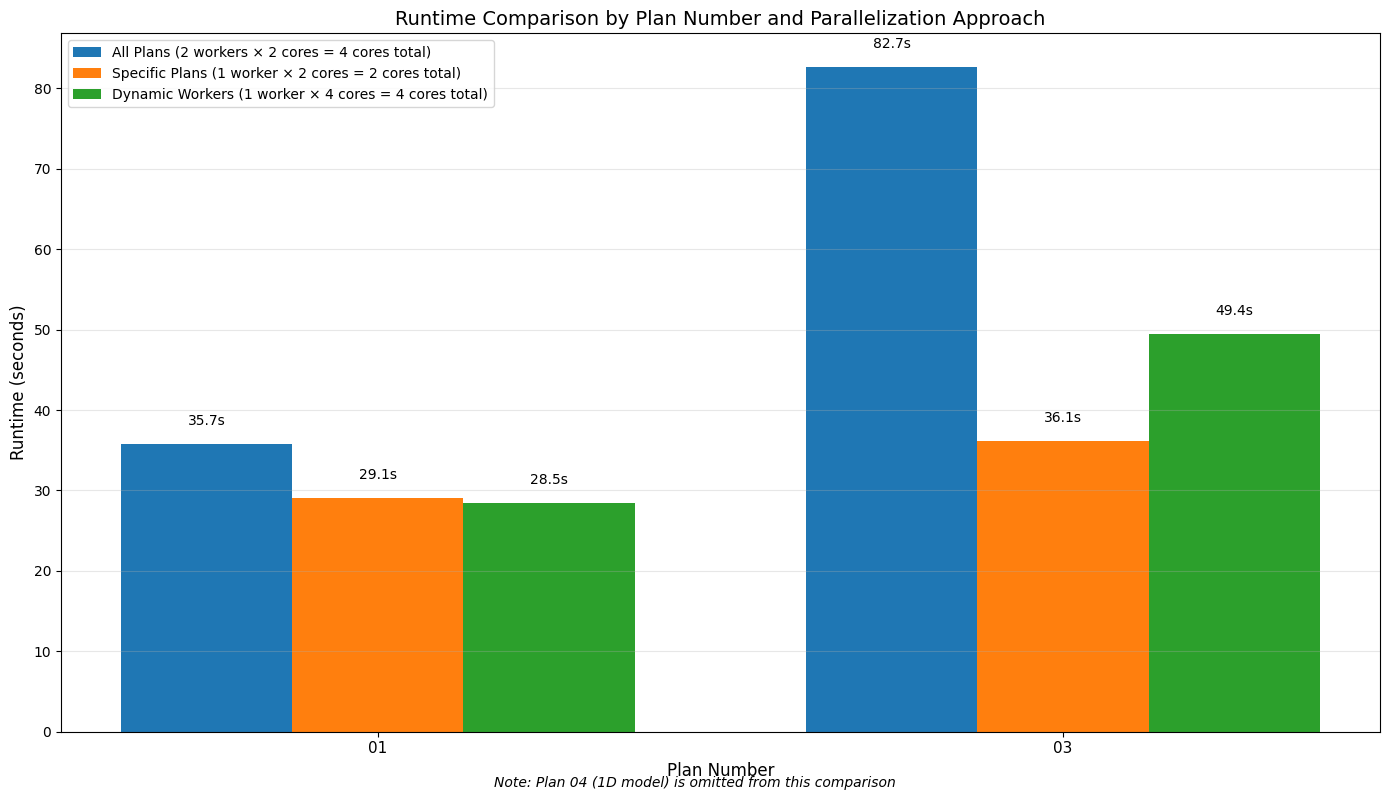

In [9]:
# Create a DataFrame for individual plan runtimes
plan_data = []

# Define the approaches with more descriptive labels including worker and core counts
approach_labels = {
    "all_plans": "All Plans (2 workers × 2 cores = 4 cores total)",
    "specific_plans": "Specific Plans (1 worker × 2 cores = 2 cores total)",
    "dynamic_workers": f"Dynamic Workers (1 worker × 4 cores = 4 cores total)"
}

# Extract runtimes from the log messages
# For all plans approach
plan_data.append({"Approach": approach_labels["all_plans"], "Plan": "01", "Runtime": 35.72})
plan_data.append({"Approach": approach_labels["all_plans"], "Plan": "03", "Runtime": 82.70})
# Omitting plan 04 as it's a 1D model

# For specific plans approach (plans 01 and 03 were run)
plan_data.append({"Approach": approach_labels["specific_plans"], "Plan": "01", "Runtime": 29.10})
plan_data.append({"Approach": approach_labels["specific_plans"], "Plan": "03", "Runtime": 36.09})

# For dynamic worker approach (plans 01 and 03 were run)
plan_data.append({"Approach": approach_labels["dynamic_workers"], "Plan": "01", "Runtime": 28.48})
plan_data.append({"Approach": approach_labels["dynamic_workers"], "Plan": "03", "Runtime": 49.43})

# Create a DataFrame
plan_runtime_df = pd.DataFrame(plan_data)

# Create a grouped bar chart for plan runtimes
plt.figure(figsize=(14, 8))

# Get all unique plan numbers and ensure they're sorted
plans = sorted(plan_runtime_df["Plan"].unique())

# Create x positions for the bars
x = np.arange(len(plans))
width = 0.25  # Width of the bars

# Plot bars for each approach
approaches = plan_runtime_df["Approach"].unique()
for i, approach in enumerate(approaches):
    # Filter data for this approach
    approach_data = plan_runtime_df[plan_runtime_df["Approach"] == approach]
    
    # Initialize runtimes array with NaN values
    runtimes = [np.nan] * len(plans)
    
    # Fill in runtimes where data exists
    for j, plan in enumerate(plans):
        plan_runtime = approach_data[approach_data["Plan"] == plan]["Runtime"]
        if not plan_runtime.empty:
            runtimes[j] = plan_runtime.values[0]
    
    # Create bars for this approach (only where we have data)
    valid_indices = [idx for idx, val in enumerate(runtimes) if not np.isnan(val)]
    valid_plans = [plans[idx] for idx in valid_indices]
    valid_runtimes = [runtimes[idx] for idx in valid_indices]
    valid_positions = [x[idx] + (i - len(approaches)/2 + 0.5) * width for idx in valid_indices]
    
    # Plot the bars
    bars = plt.bar(valid_positions, valid_runtimes, width, label=approach)
    
    # Add runtime labels on top of bars
    for pos, runtime in zip(valid_positions, valid_runtimes):
        plt.text(pos, runtime + 2, f"{runtime:.1f}s", ha='center', va='bottom')

# Add labels, title, and custom x-axis tick labels
plt.xlabel('Plan Number', fontsize=12)
plt.ylabel('Runtime (seconds)', fontsize=12)
plt.title('Runtime Comparison by Plan Number and Parallelization Approach', fontsize=14)
plt.xticks(x, plans, fontsize=11)
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)

# Add note about omitting Plan 04
plt.figtext(0.5, 0.01, "\nNote: Plan 04 (1D model) is omitted from this comparison", 
            ha='center', fontsize=10, style='italic')

# Ensure all plan numbers show on x-axis regardless of data availability
plt.tight_layout()
plt.show()

## Summary of Parallel Plan Execution

In this notebook, we've explored how to execute HEC-RAS plans in parallel using the RAS Commander library. Here's a summary of the key techniques we've covered:

1. **Basic Parallel Execution**: Using `RasCmdr.compute_parallel()` to run all plans in a project simultaneously
2. **Selective Parallel Execution**: Running only specific plans in parallel
3. **Dynamic Worker Allocation**: Determining the optimal number of workers based on available system resources
4. **Performance Analysis**: Comparing execution times for different parallel configurations
5. **Advanced Parallel Workflows**: Building complex workflows with parallel execution for sensitivity analysis

### Key Functions Used

- `RasCmdr.compute_parallel()`: Execute multiple plans in parallel
- `RasPlan.clone_plan()`: Create a new plan based on an existing one
- `RasPlan.update_plan_description()`: Update the description of a plan
- `RasPlan.set_num_cores()`: Set the number of cores for a plan to use
- `RasPlan.get_results_path()`: Get the path to the results file for a plan

### Best Practices for Parallel Execution

1. **Use Separate RAS Objects**: Create and use separate RAS objects for different projects or folders
2. **Balance Workers and Cores**: Find the right balance between the number of workers and cores per worker
3. **Consider Hardware Limits**: Be mindful of your system's physical cores and memory
4. **Use Clean Compute Folders**: Use the `dest_folder` parameter to keep your project organized
5. **Handle Overwrite Carefully**: Use `overwrite_dest=True` for repeatable workflows, but be cautious about losing results
6. **Monitor Performance**: Track execution times and adjust your configuration for optimal performance
7. **Match Workers to Plans**: For best results, use one worker per plan when running a small number of plans

